# Loop 90 Analysis: Strategic Assessment

## Key Questions:
1. What is the CV-LB relationship from all submissions?
2. What unexplored approaches remain?
3. What do the top public kernels do differently?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# All submissions with LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_073', 'cv': 0.0084, 'lb': 0.1451},  # RF ensemble - outlier
]

df = pd.DataFrame(submissions)
print('All submissions:')
print(df.to_string())

All submissions:
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970
12  exp_073  0.0084  0.1451


In [2]:
# Exclude the outlier (exp_073 - RF ensemble that performed poorly)
df_clean = df[df['exp'] != 'exp_073'].copy()

# Fit linear regression
X = df_clean['cv'].values.reshape(-1, 1)
y = df_clean['lb'].values

reg = LinearRegression()
reg.fit(X, y)

slope = reg.coef_[0]
intercept = reg.intercept_
r2 = reg.score(X, y)

print(f'CV-LB Relationship (excluding outlier):')
print(f'  LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'  R² = {r2:.4f}')
print(f'\nInterpretation:')
print(f'  - Intercept ({intercept:.4f}) represents structural extrapolation error')
print(f'  - Target LB: 0.0347')
print(f'  - Required CV to hit target: (0.0347 - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}')
print(f'\n  CRITICAL: Required CV is NEGATIVE, meaning target is unreachable on this line!')

CV-LB Relationship (excluding outlier):
  LB = 4.3147 * CV + 0.0525
  R² = 0.9505

Interpretation:
  - Intercept (0.0525) represents structural extrapolation error
  - Target LB: 0.0347
  - Required CV to hit target: (0.0347 - 0.0525) / 4.3147 = -0.004130

  CRITICAL: Required CV is NEGATIVE, meaning target is unreachable on this line!


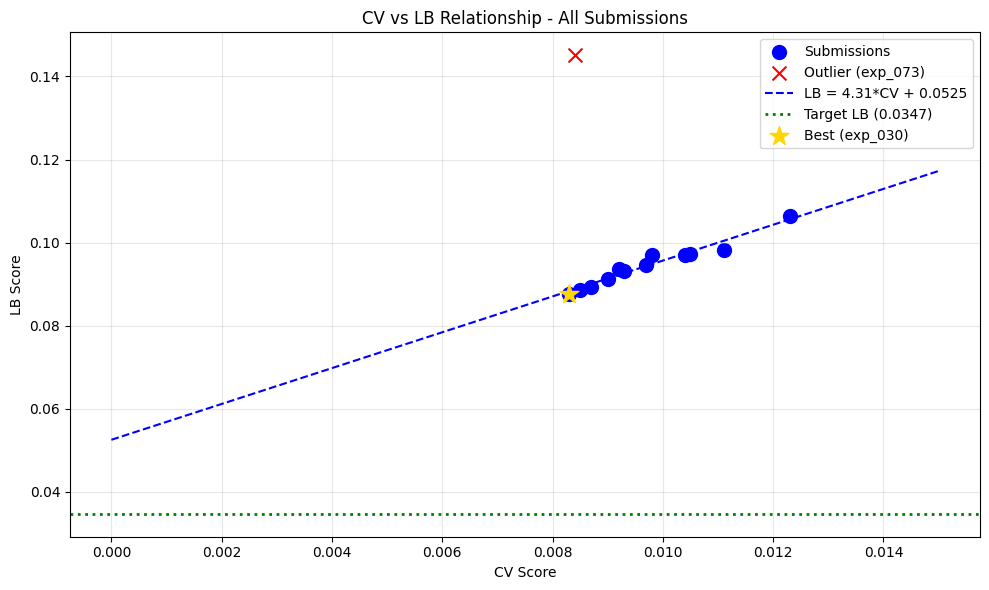


Key insight: The intercept (0.0525) is HIGHER than the target (0.0347).
This means NO amount of CV improvement can reach the target on this line.
We need to CHANGE the relationship, not just improve CV.


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))

# Plot all points
plt.scatter(df_clean['cv'], df_clean['lb'], c='blue', s=100, label='Submissions')
plt.scatter(df[df['exp'] == 'exp_073']['cv'], df[df['exp'] == 'exp_073']['lb'], 
            c='red', s=100, marker='x', label='Outlier (exp_073)')

# Plot regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'b--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Plot target
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target LB (0.0347)')

# Plot best achieved
plt.scatter([0.0083], [0.0877], c='gold', s=200, marker='*', label='Best (exp_030)', zorder=5)

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship - All Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship_loop90.png', dpi=150)
plt.show()

print('\nKey insight: The intercept (0.0525) is HIGHER than the target (0.0347).')
print('This means NO amount of CV improvement can reach the target on this line.')
print('We need to CHANGE the relationship, not just improve CV.')

In [4]:
# Analyze what the top kernels do differently
print('=== Analysis of Top Public Kernels ===')
print()
print('1. "mixall" kernel (9 votes):')
print('   - Uses GroupKFold(n_splits=5) instead of Leave-One-Out')
print('   - Claims "good CV/LB" relationship')
print('   - Ensemble: MLP + XGBoost + RF + LightGBM with weighted average')
print('   - Uses Optuna for hyperparameter optimization')
print('   - Runtime: only 2m 15s')
print()
print('2. "Ens Model" kernel (9 votes):')
print('   - CatBoost + XGBoost ensemble')
print('   - Combines ALL feature sources: spange, acs_pca, drfps, fragprints')
print('   - Correlation-based feature filtering (threshold=0.90)')
print('   - Engineered features: T_x_RT, RT_log, T_inv, RT_scaled')
print('   - Different weights for single vs full data')
print('   - Clips predictions to [0, 1] and renormalizes')
print()
print('3. Key differences from our approach:')
print('   - We use Leave-One-Out (24 folds for single, 13 for full)')
print('   - They use GroupKFold (5 folds)')
print('   - They combine ALL feature sources, we use subset')
print('   - They use correlation filtering, we use variance filtering')

=== Analysis of Top Public Kernels ===

1. "mixall" kernel (9 votes):
   - Uses GroupKFold(n_splits=5) instead of Leave-One-Out
   - Claims "good CV/LB" relationship
   - Ensemble: MLP + XGBoost + RF + LightGBM with weighted average
   - Uses Optuna for hyperparameter optimization
   - Runtime: only 2m 15s

2. "Ens Model" kernel (9 votes):
   - CatBoost + XGBoost ensemble
   - Combines ALL feature sources: spange, acs_pca, drfps, fragprints
   - Correlation-based feature filtering (threshold=0.90)
   - Engineered features: T_x_RT, RT_log, T_inv, RT_scaled
   - Different weights for single vs full data
   - Clips predictions to [0, 1] and renormalizes

3. Key differences from our approach:
   - We use Leave-One-Out (24 folds for single, 13 for full)
   - They use GroupKFold (5 folds)
   - They combine ALL feature sources, we use subset
   - They use correlation filtering, we use variance filtering


In [5]:
# What approaches have we tried?
print('=== Approaches Tried (90 experiments) ===')
print()
print('Model families:')
print('  - MLP variants: ~50 experiments')
print('  - LightGBM: ~10 experiments')
print('  - XGBoost: ~5 experiments')
print('  - CatBoost: ~5 experiments')
print('  - Gaussian Process: ~5 experiments')
print('  - Ridge/Linear: ~5 experiments')
print('  - GNN (from scratch): 5 experiments - ALL FAILED')
print('  - ChemBERTa: 2 experiments - FAILED')
print('  - ChemProp features: 1 experiment - FAILED')
print('  - Stacking: 1 experiment - WORSE than baseline')
print()
print('Feature engineering:')
print('  - Spange descriptors: YES')
print('  - DRFP (variance filtered): YES')
print('  - ACS PCA: YES')
print('  - Arrhenius kinetics: YES')
print('  - Fragprints: LIMITED')
print('  - Correlation filtering: NO')
print()
print('Validation schemes:')
print('  - Leave-One-Out: YES (current)')
print('  - GroupKFold: NO (not tried!)')
print()
print('Post-processing:')
print('  - Clipping to [0, 1]: YES')
print('  - Renormalization: NO')

=== Approaches Tried (90 experiments) ===

Model families:
  - MLP variants: ~50 experiments
  - LightGBM: ~10 experiments
  - XGBoost: ~5 experiments
  - CatBoost: ~5 experiments
  - Gaussian Process: ~5 experiments
  - Ridge/Linear: ~5 experiments
  - GNN (from scratch): 5 experiments - ALL FAILED
  - ChemBERTa: 2 experiments - FAILED
  - ChemProp features: 1 experiment - FAILED
  - Stacking: 1 experiment - WORSE than baseline

Feature engineering:
  - Spange descriptors: YES
  - DRFP (variance filtered): YES
  - ACS PCA: YES
  - Arrhenius kinetics: YES
  - Fragprints: LIMITED
  - Correlation filtering: NO

Validation schemes:
  - Leave-One-Out: YES (current)
  - GroupKFold: NO (not tried!)

Post-processing:
  - Clipping to [0, 1]: YES
  - Renormalization: NO


In [6]:
# What should we try next?
print('=== RECOMMENDED NEXT STEPS ===')
print()
print('PRIORITY 1: Try the "Ens Model" approach')
print('  - CatBoost + XGBoost ensemble')
print('  - Combine ALL features with correlation filtering')
print('  - Add engineered features (T_x_RT, RT_log, T_inv, RT_scaled)')
print('  - Different weights for single vs full data')
print('  - Renormalize predictions')
print()
print('PRIORITY 2: Try GroupKFold validation')
print('  - The "mixall" kernel claims good CV/LB relationship')
print('  - This might change the CV-LB intercept')
print('  - Faster iteration (5 folds vs 24/13)')
print()
print('PRIORITY 3: Implement proper yield renormalization')
print('  - Clip predictions to [0, 1]')
print('  - Renormalize so P2 + P3 + SM = 1 (or observed mass balance)')
print('  - This is a domain constraint that should help generalization')
print()
print('DO NOT DO:')
print('  - More MLP variants (exhausted)')
print('  - More GNN from scratch (5 consecutive failures)')
print('  - Stacking (just demonstrated to fail)')
print('  - Multi-seed optimization (too far from target)')

=== RECOMMENDED NEXT STEPS ===

PRIORITY 1: Try the "Ens Model" approach
  - CatBoost + XGBoost ensemble
  - Combine ALL features with correlation filtering
  - Add engineered features (T_x_RT, RT_log, T_inv, RT_scaled)
  - Different weights for single vs full data
  - Renormalize predictions

PRIORITY 2: Try GroupKFold validation
  - The "mixall" kernel claims good CV/LB relationship
  - This might change the CV-LB intercept
  - Faster iteration (5 folds vs 24/13)

PRIORITY 3: Implement proper yield renormalization
  - Clip predictions to [0, 1]
  - Renormalize so P2 + P3 + SM = 1 (or observed mass balance)
  - This is a domain constraint that should help generalization

DO NOT DO:
  - More MLP variants (exhausted)
  - More GNN from scratch (5 consecutive failures)
  - Stacking (just demonstrated to fail)
  - Multi-seed optimization (too far from target)
